# ECG Analysis - Sleep Patterns
##### Given a sample file containing 32399 seconds (~9 hours) of ECG data with a sample rate of 250hz (32399*250=8.099.750 lines) we will proceed to analyze the signal in order to predict the various sleep stages.
> We can confirm our guesses with the sleep.txt file that contains accurate sleep stages for 30 second intervals

# Methodology

 - Find r-peaks with a threshold of 0.35mV in order to then find the rr intervals to give us an understanding of the heart rate variability in the given sample file
 - Resample to a lower sample rate if the signal is fuzzy
 - Calculate the total power of the signal
 - Calculate VLF,LF,HF,LF/HF ratio
 > VLF (0.0033-0.04)

 > LF (0.04-0.15)
 
 > HF (0.15-0.4) 
 - Create predictions for the sleep stages based on the features calculated above for every 30 seconds
 - Compare with sleep.txt 
 > LF<0.296 && ratio<=3.37 = REM_Wake

 > LF<=0.296 && ratio>3.37 = NREM

 > LF>0.296 && total<=0.186 = NREM
 
 > LF>0.296 && total>0.186 = REM_Wake

In [197]:
"""
Imports , DataVisualization, Pandas, Matplotlib, Seaborn, Numpy
"""
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import scipy as sp
import scipy.signal 


In [143]:
"""
Setup global variables and plot style&colors
"""
settings = {}
settings['fs']=250

'''
Change color of seaborn plots bg
'''
sns.set_style('whitegrid')
sns.set_context('paper')
sns.set_palette('deep')

'''
Change pyplot color palette
'''
plt.style.use('seaborn-deep')


In [158]:
'''
Load The file with the data and parse it to a DataFrame
The dataframe will have 2 columns:
 -  'Seconds'
 -  'ECG'
'''
df = pd.read_csv('ecg.csv', sep=',', header=None, names=['Seconds', 'ECG'],low_memory=False)
'''
We will delete the first row because it contains the column names, and make sure the data is numeric
'''
df = df.drop(df.index[0])
df = df.apply(pd.to_numeric)

8099750


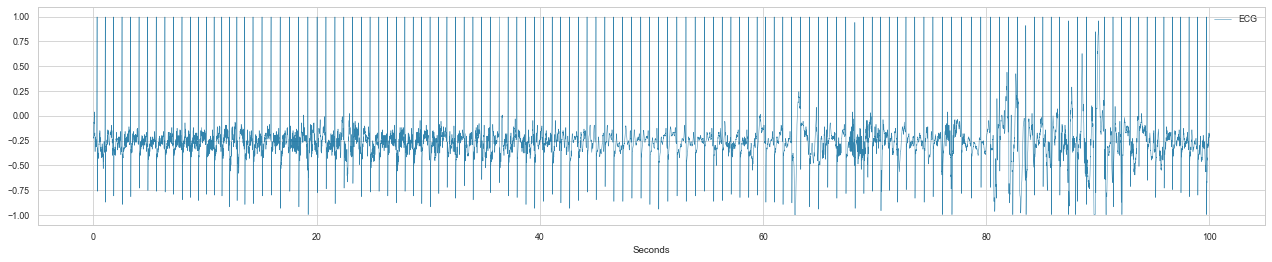

In [145]:
'''
Take a glimpse of the dataframe to see what we have 
also visualize the first 100 seconds using seaborn
'''
duration = 100 * settings['fs']
df.head(duration).plot(x='Seconds', y='ECG', color='#006699', linewidth=0.5, alpha=0.8, figsize=(22, 4))

#print length of dataframe
print(len(df))


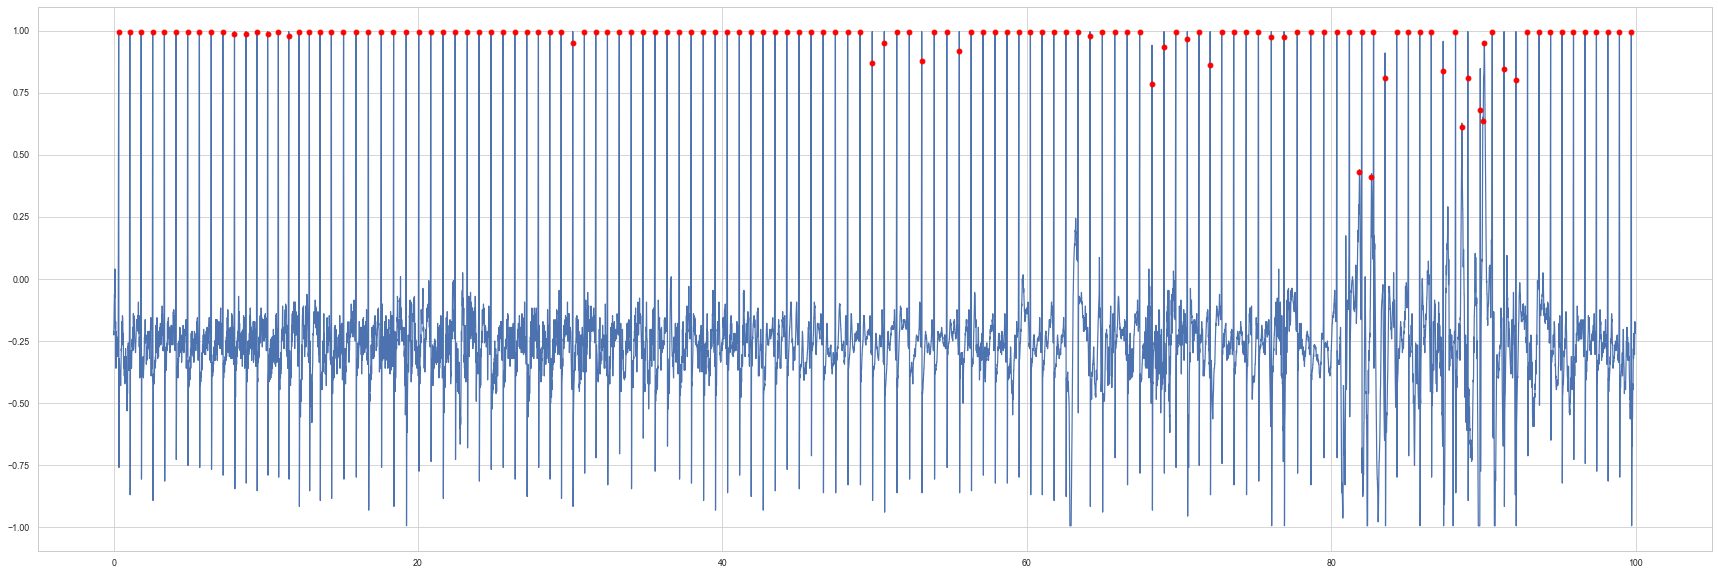

In [146]:
'''
Lets find the r peaks with a 0.35mV threshold
'''
r_peaks = sig.find_peaks(df['ECG'][0:25000],height=0.35)

'''
Plot the r peaks on the ECG signal
'''
plt.figure(figsize=(30, 10))
plt.plot(df['Seconds'][0:25000], df['ECG'][0:25000])
plt.plot(df['Seconds'][r_peaks[0]], df['ECG'][r_peaks[0]], 'ro')


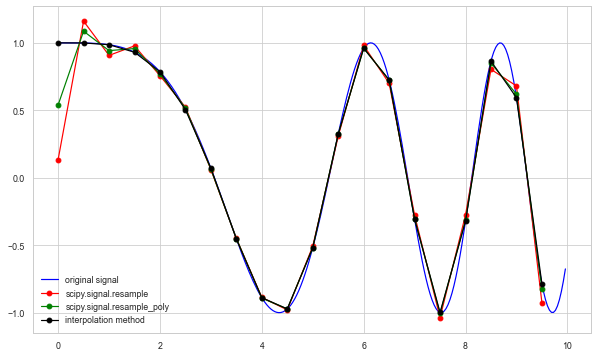

In [147]:
'''
As we can see, the r peaks are mostly false positives.
We need to resample the signal to a lower frequency to find the r peaks again.
'''

# DISCLAIMER: This function is copied from https://github.com/nwhitehead/swmixer/blob/master/swmixer.py,
#             which was released under LGPL.
def resample_by_interpolation(signal, input_fs, output_fs):

    scale = output_fs / input_fs
    # calculate new length of sample
    n = round(len(signal) * scale)

    # use linear interpolation
    # endpoint keyword means than linspace doesn't go all the way to 1.0
    # If it did, there are some off-by-one errors
    # e.g. scale=2.0, [1,2,3] should go to [1,1.5,2,2.5,3,3]
    # but with endpoint=True, we get [1,1.4,1.8,2.2,2.6,3]
    # Both are OK, but since resampling will often involve
    # exact ratios (i.e. for 44100 to 22050 or vice versa)
    # using endpoint=False gets less noise in the resampled sound
    resampled_signal = np.interp(
        np.linspace(0.0, 1.0, n, endpoint=False),  # where to interpret
        np.linspace(0.0, 1.0, len(signal), endpoint=False),  # known positions
        signal,  # known data points
    )
    return resampled_signal


x = np.linspace(0, 10, 256, endpoint=False)
y = np.cos(-x**2/6.0)
yre = scipy.signal.resample(y, 20)
xre = np.linspace(0, 10, len(yre), endpoint=False)

yre_polyphase = scipy.signal.resample_poly(y, 20, 256)
yre_interpolation = resample_by_interpolation(y, 256, 20)

plt.figure(figsize=(10, 6))
plt.plot(x, y, 'b', xre, yre, 'or-')
plt.plot(xre, yre_polyphase, 'og-')
plt.plot(xre, yre_interpolation, 'ok-')
plt.legend(['original signal', 'scipy.signal.resample',
           'scipy.signal.resample_poly', 'interpolation method'], loc='lower left')
plt.show()

ecg_2hz = resample_by_interpolation(df['ECG'], settings['fs'], 2)
ecg_20hz = resample_by_interpolation(df['ECG'], settings['fs'], 20)
ecg_50hz = resample_by_interpolation(df['ECG'], settings['fs'], 50)
ecg_100hz = resample_by_interpolation(df['ECG'], settings['fs'], 100)


In [148]:
'''
Lets create the dataframe with the resampled data 
'''
df_2hz = pd.DataFrame(ecg_2hz, columns=['ECG'])
df_2hz['Seconds'] = np.arange(0, len(df_2hz)) / 2

df_20hz = pd.DataFrame(ecg_20hz, columns=['ECG'])
df_20hz['Seconds'] = np.arange(0, len(df_20hz)) / 20

df_50hz = pd.DataFrame(ecg_50hz, columns=['ECG'])
df_50hz['Seconds'] = np.arange(0, len(df_50hz)) / 50

df_100hz = pd.DataFrame(ecg_100hz, columns=['ECG']) 
df_100hz['Seconds'] = np.arange(0, len(df_100hz)) / 100


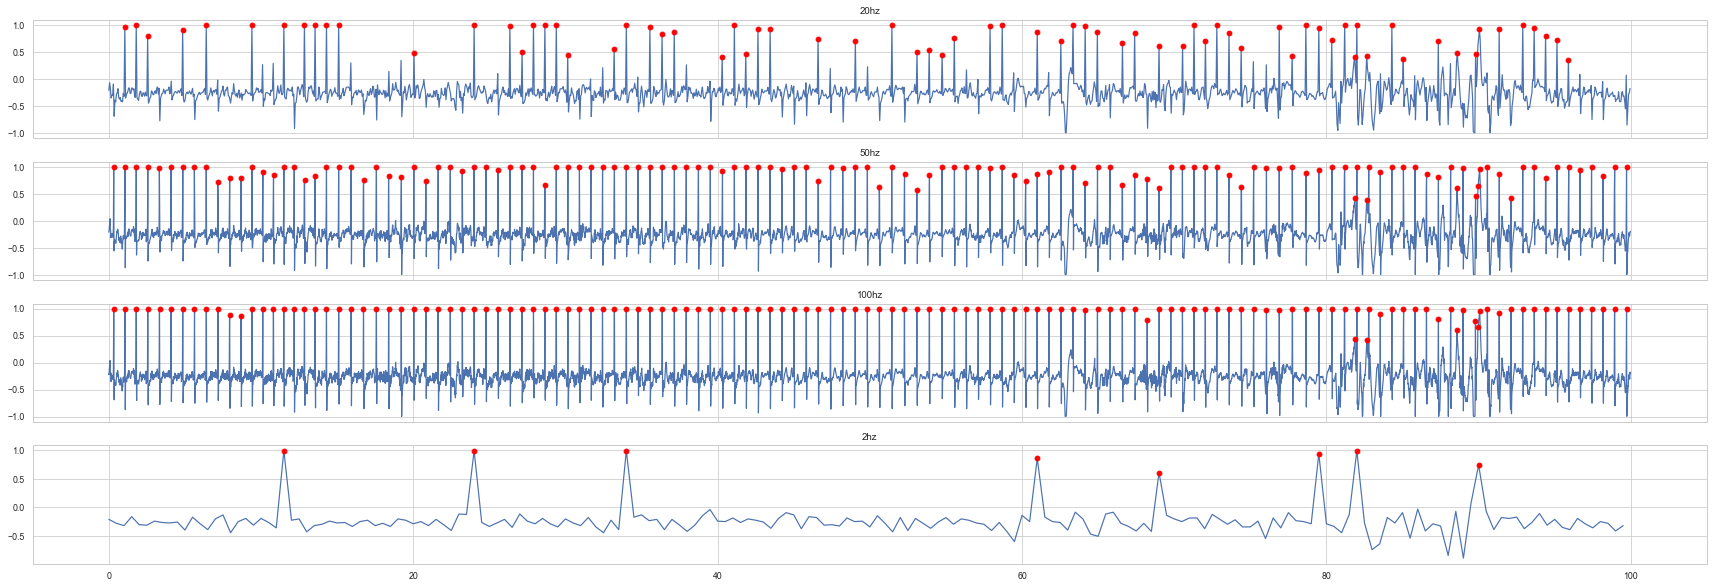

In [149]:
'''
Find r_peaks for the first 100 seconds of the resampled data and plot them 
'''

r_peaks_2hz = scipy.signal.find_peaks(df_2hz['ECG'][0:200], height=0.35)
r_peaks_20hz = scipy.signal.find_peaks(df_20hz['ECG'][0:2000],height=0.35)
r_peaks_50hz = scipy.signal.find_peaks(df_50hz['ECG'][0:5000], height=0.35)
r_peaks_100hz = scipy.signal.find_peaks(df_100hz['ECG'][0:10000], height=0.35)
#we will have 4 plots so we need to create a figure with 3 subplots
fig, ax = plt.subplots(4, 1, sharex=True, figsize=(30, 10))
#create the 20hz plot and plot the r peaks on top of the ECG signal
ax[0].plot(df_20hz['Seconds'][0:2000], df_20hz['ECG'][0:2000])
ax[0].plot(df_20hz['Seconds'][r_peaks_20hz[0]], df_20hz['ECG'][r_peaks_20hz[0]], 'ro')
ax[0].set_title('20hz')
#create the 50hz plot and plot the r peaks on top of the ECG signal
ax[1].plot(df_50hz['Seconds'][0:5000], df_50hz['ECG'][0:5000])
ax[1].plot(df_50hz['Seconds'][r_peaks_50hz[0]], df_50hz['ECG'][r_peaks_50hz[0]], 'ro')
ax[1].set_title('50hz')
#create the 100hz plot and plot the r peaks on top of the ECG signal
ax[2].plot(df_100hz['Seconds'][0:10000], df_100hz['ECG'][0:10000])
ax[2].plot(df_100hz['Seconds'][r_peaks_100hz[0]], df_100hz['ECG'][r_peaks_100hz[0]], 'ro')
ax[2].set_title('100hz')
#create the 2hz plot and plot the r peaks on top of the ECG signal
ax[3].plot(df_2hz['Seconds'][0:200], df_2hz['ECG'][0:200])
ax[3].plot(df_2hz['Seconds'][r_peaks_2hz[0]], df_2hz['ECG'][r_peaks_2hz[0]], 'ro')
ax[3].set_title('2hz')
#show the plot
plt.show()



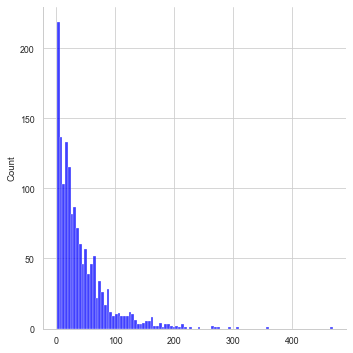

In [150]:
'''
As we can see we want to keep the 2hz signal,
lets find all the r peaks in the resampled data and plot them
'''

r_peaks_2hz = scipy.signal.find_peaks(df_2hz['ECG'], height=0.35)
rr_intervals_2hz = np.diff(r_peaks_2hz[0])

#create a chart with the rr intervals using seaborn to visualize the variability
sns.displot(rr_intervals_2hz, bins=100, kde=False, color='blue')


In [151]:
'''
Now that we have the rr intervals and the r peaks we can create a welch periodogram to see the frequency content of the signal 
'''
welch_2hz = scipy.signal.welch(df_2hz['ECG'], fs=2)
#use the signal.periodogram to create a periodogram for every 30 seconds of the resampled data (30 seconds = 60 entries)
periodogram_2hz = [];
for i in range(0, len(df_2hz['ECG'])-60, 60):
    periodogram_2hz.append(scipy.signal.periodogram(df_2hz['ECG'][i:i+60], fs=2))




 > VLF (0.0033-0.04)

 > LF (0.04-0.15)
 
 > HF (0.15-0.4) 
 

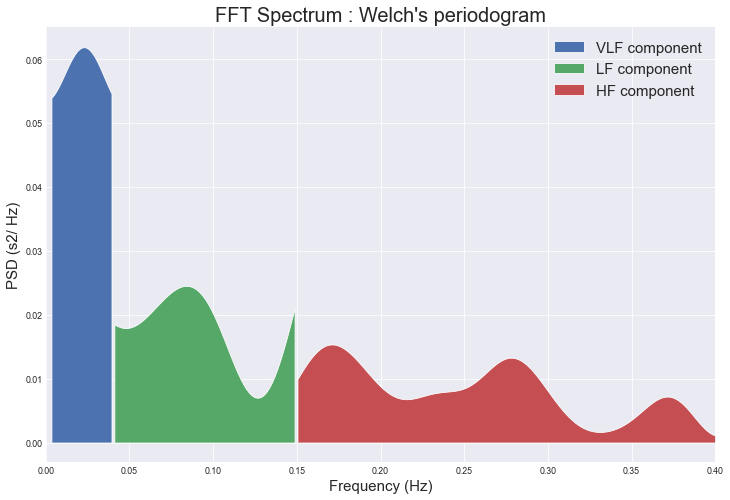

C:\Users\Support\AppData\Local\Temp\ipykernel_18892\1945364369.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['VLF'][i] = periodogram_2hz[i][1][0]
C:\Users\Support\AppData\Local\Temp\ipykernel_18892\1945364369.py:18: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['LF'][i] = periodogram_2hz[i][1][1]
C:\Users\Support\AppData\Local\Temp\ipykernel_18892\1945364369.py:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-c

In [160]:
'''
Start  Power Spectral Density (PSD) analysis by visualizing the PSD of the signal
'''

plot_psd(rr_intervals_2hz, method="welch")

'''
create new dataframe with columns Seconds,VLF, LF, HF, LF_HF_ratio,total_power
'''
predictions = pd.DataFrame(columns=['Seconds', 'VLF', 'LF', 'HF', 'LF_HF_ratio', 'total_power'])

#fill up seconds in 30 seconds intervals for 1079 entries
predictions['Seconds'] = np.arange(0, 32370, 30)

#fill up the VLF, LF, HF, LF_HF_ratio, total_power columns
for i in range(0, len(predictions['Seconds'])):
    predictions['VLF'][i] = periodogram_2hz[i][1][0]
    predictions['LF'][i] = periodogram_2hz[i][1][1]
    predictions['HF'][i] = periodogram_2hz[i][1][2]
    predictions['LF_HF_ratio'][i] = periodogram_2hz[i][1][1] / periodogram_2hz[i][1][2]
    predictions['total_power'][i] = periodogram_2hz[i][1][0] + periodogram_2hz[i][1][1] + periodogram_2hz[i][1][2]


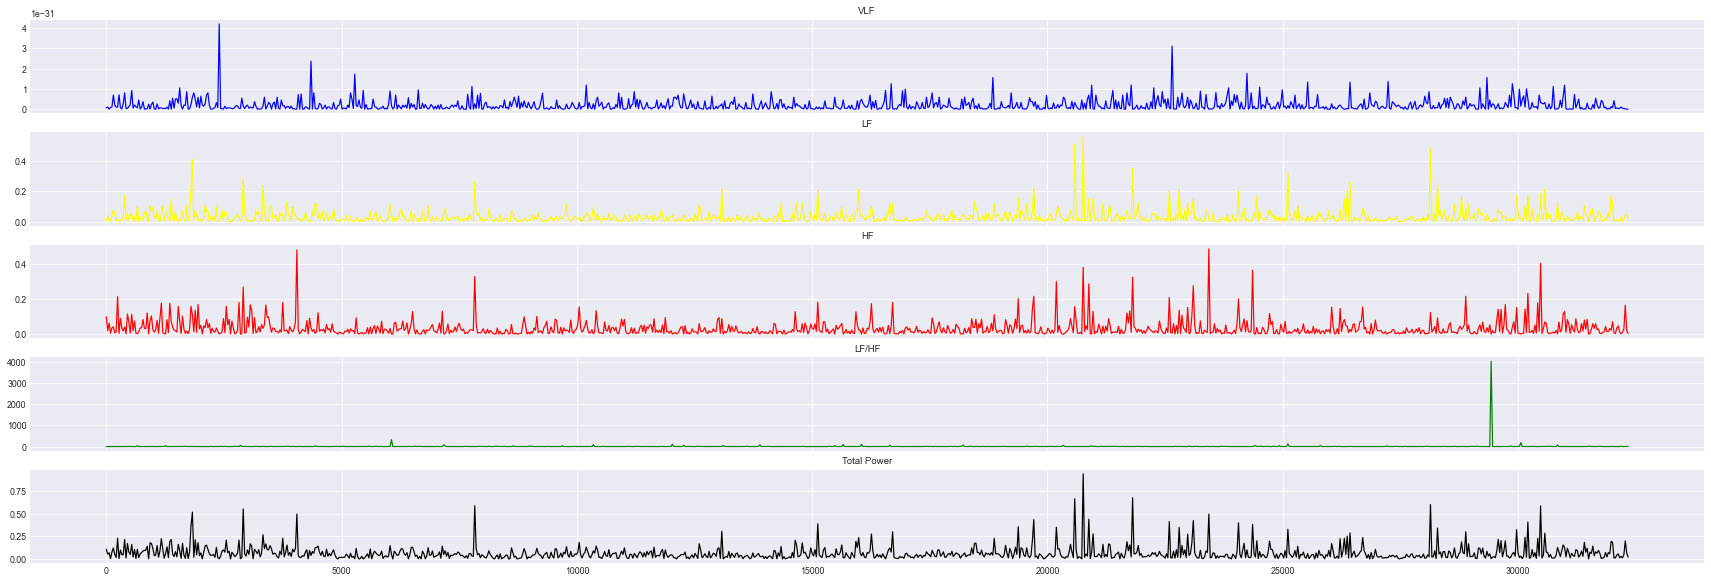

In [165]:
#plot the predictions using pyplot in a canvas
#add title and labels
#create group of 5 plots
fig, ax = plt.subplots(5, 1, sharex=True, figsize=(30, 10))
#plot each column in the dataframe with a different color
ax[0].plot(predictions['Seconds'], predictions['VLF'], color='blue')
ax[0].set_title('VLF')
ax[1].plot(predictions['Seconds'], predictions['LF'], color='yellow')
ax[1].set_title('LF')
ax[2].plot(predictions['Seconds'], predictions['HF'], color='red')
ax[2].set_title('HF')
ax[3].plot(predictions['Seconds'], predictions['LF_HF_ratio'], color='green')
ax[3].set_title('LF/HF')
ax[4].plot(predictions['Seconds'], predictions['total_power'], color='black')
ax[4].set_title('Total Power')
#show the plot
plt.show()

C:\Users\Support\AppData\Local\Temp\ipykernel_18892\818918905.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  predictions['Prediction'][i] = 'REM_Wake'


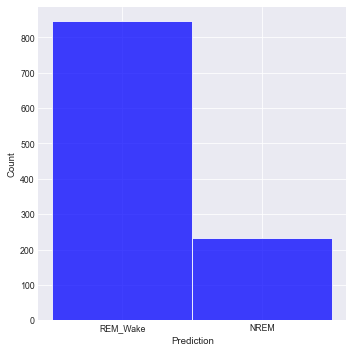

In [176]:
'''
Add a prediction column to the dataframe
 > LF<0.296 && ratio<=3.37 = REM_Wake

 > LF<=0.296 && ratio>3.37 = NREM

 > LF>0.296 && total<=0.186 = NREM
 
 > LF>0.296 && total>0.186 = REM_Wake
'''
predictions['Prediction'] = np.nan
for i in range(0, len(predictions['Seconds'])):
    if predictions['LF'][i] <= 0.296 and predictions['LF_HF_ratio'][i] <= 3.37:
        predictions['Prediction'][i] = 'REM_Wake'
    elif predictions['LF'][i] <= 0.296 and predictions['LF_HF_ratio'][i] > 3.37:
        predictions['Prediction'][i] = 'NREM'
    elif predictions['LF'][i] > 0.296 and predictions['total_power'][i] <= 0.186:
        predictions['Prediction'][i] = 'NREM'
    elif predictions['LF'][i] > 0.296 and predictions['total_power'][i] > 0.186:
        predictions['Prediction'][i] = 'REM_Wake'

#visualize the predictions using seaborn
sns.displot(predictions['Prediction'], bins=100, kde=False, color='blue')

In [196]:
'''
load sleep.txt and compare the predictions with the actual sleep stage
'''
results = pd.read_csv('sleep.txt', sep='\t', header=None)
results.columns = ['Seconds', 'Sleep Stage']
#delete the first row
results = results.drop(results.index[0])
#delete the last row since we have 1079 and not 1080
results = results.drop(results.index[-1])
#compare the predictions with the actual sleep stage
guesses = predictions['Prediction'].to_numpy()
actual = results['Sleep Stage'].to_numpy()
#get percentage of correct guesses
correct = 0
for i in range(0, len(guesses)):
    if guesses[i] == actual[i]:
        correct += 1
#print the percentage of correct guesses with only 2 decimals
print('{:.2f}%'.format(correct/len(guesses)*100))


44.30%
